# DEEP LEARNING FOR MEDICAL IMAGE ANALYSIS
Practical block I: Dermatological moles segmentation

João Valério

joao.agostinho@estudiantat.upc.edu

31/10/2023

# Introduction

Skin cancer is a major public health problem, with over 5,000,000 newly diagnosed cases in the United States every year. Melanoma is the deadliest form of skin cancer, responsible for an overwhelming majority of skin cancer deaths. In 2015, the global incidence of melanoma was estimated to be over 350,000 cases, with almost 60,000 deaths. Although the mortality is significant, when detected early, melanoma survival exceeds 95%.

# Work Strategy

In this section, it is essential to outline the process to be followed in this work:

1.   We will begin by utilizing the Unet architecture described in the paper, which can be found at https://keras.io/examples/vision/oxford_pets_image_segmentation/, as it is a requirement. Our primary objective is to optimize the model structure to enhance its performance based on the available dataset. Thus, the initial focus is entirely on the model's development and refinement.
2.   After obtaining the optimal model for our dataset, we will explore a range of data preprocessing techniques. The choice of preprocessing tools will be contingent on the model's performance, following a feedback-driven approach.

In conclusion, we will analyze and discuss all the results. It's important to reiterate that only a subset of the data is used during the code development phase. Moreover, the best configuration in the different tests is selected based on the Jaccard Index, however, on the analysis all the metrics will be considered.

# Code & Analysis

## Required Libraries

In [1]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
import tensorflow_datasets as tfds
import random
import cv2
from sklearn.model_selection import train_test_split
from keras import backend as K
from tensorflow.python.keras import losses
from skimage.feature import canny
from scipy.ndimage import convolve, gaussian_laplace
from sklearn.model_selection import KFold

## Upload Data

Data is uploaded directly from the drive to conserve RAM while developing code on Colab. The variable 'num_images_to_load' empowers us to regulate the number of images we wish to import from the drive. In the interest of resource and time efficiency, we will import only a portion of the data. This approach enables us to conduct more tests without risking system crashes and accelerates the testing phase.

In [2]:
drive.mount('/content/drive')
training_data_dir = '/content/drive/My Drive/DLMIA/ISBI2016_ISIC_Part1_Training_Data'
target_data_dir = '/content/drive/My Drive/DLMIA/ISBI2016_ISIC_Part1_Training_GroundTruth'

def load_images_from_folder(folder, num_images):
    images = []
    file_list = sorted(os.listdir(folder)[:num_images])
    for filename in file_list:
        if folder == '/content/drive/My Drive/DLMIA/ISBI2016_ISIC_Part1_Training_Data':
          img = load_img(os.path.join(folder, filename))
        else: img = load_img(os.path.join(folder, filename), color_mode='grayscale')
        img = img_to_array(img)
        images.append(img)
    return np.array(images)

num_images_to_load = 200
X_train = load_images_from_folder(training_data_dir, num_images_to_load)
Y_train = load_images_from_folder(target_data_dir, num_images_to_load)

Mounted at /content/drive


<ipython-input-2-33ab6f3a2261>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(images)


## Example

This serves as a fundamental illustration of a single image paired with its corresponding ground truth.

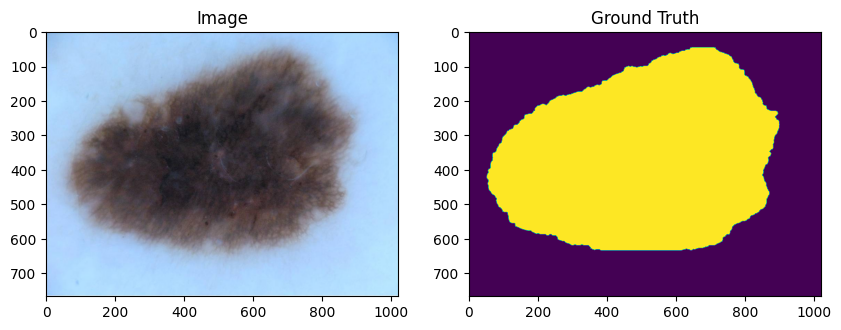

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.set_title("Image")
ax2.set_title("Ground Truth")
ax1.imshow(X_train[0]/255)
ax2.imshow(Y_train[0])
plt.show()

## Basic Data Preprocessing

In this step, we resize the dimensions to 128 in both height and width and perform a split, allocating 80% for training and 20% for testing.

In [4]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

resized_X_train = np.empty((X_train.shape[0], IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
resized_Y_train = np.empty((Y_train.shape[0], IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

for i in range(X_train.shape[0]):
    resized_X_train[i] = cv2.resize(X_train[i], (IMG_WIDTH, IMG_HEIGHT))
    resized_Y_train[i] = np.expand_dims(cv2.resize(Y_train[i], (IMG_WIDTH, IMG_HEIGHT)), axis=-1)

# Split 80% train; 20% test
X_train = resized_X_train[:int(resized_X_train.shape[0]*0.8)]
X_test = resized_X_train[int(resized_X_train.shape[0]*0.8):]
Y_train = resized_Y_train[:int(resized_Y_train.shape[0]*0.8)]
Y_test = resized_Y_train[int(resized_Y_train.shape[0]*0.8):]

print('Number of Train Images = {}'.format(X_train.shape[0]))
print('Number of Test Images = {}'.format(X_test.shape[0]))
print('\n')
print('Images Shape = {}'.format(X_test[0].shape))
print('Target Images Shape = {}'.format(Y_test[0].shape))

Number of Train Images = 160
Number of Test Images = 40


Images Shape = (128, 128, 3)
Target Images Shape = (128, 128, 1)


<ipython-input-4-342083425658>:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  resized_Y_train = np.empty((Y_train.shape[0], IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)


In [5]:
## Train
X_TRAIN_IMAGE = tf.constant(X_train, dtype=tf.float32)
Y_TRAIN_TARGET = tf.constant(Y_train, dtype=tf.float32)
## Test
X_TEST_IMAGE = tf.constant(X_test, dtype=tf.float32)
Y_TEST_TARGET = tf.constant(Y_test, dtype=tf.float32)

'''
del X_train
del X_test
del Y_train
del Y_test
del resized_X_train
del resized_Y_train
'''

'\ndel X_train\ndel X_test\ndel Y_train\ndel Y_test\ndel resized_X_train\ndel resized_Y_train\n'

## Evaluation Metrics

We have implemented the evaluation metrics recommended by the challenge, which include:

*   Sensitivity
*   Specificity
*   Dice coefficient
*   Jaccard index
*   Accuracy

It's worth noting that all of these metrics are self-implemented, except for accuracy.

In [6]:
## Evaluation Metrics
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def dice_coefficient(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean((2.0 * intersection + K.epsilon()) / (union + K.epsilon()), axis=0)

def jaccard_index(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    return K.mean((intersection + K.epsilon()) / (union + K.epsilon()), axis=0)

In [7]:
# Print the results
def model_results(model, X=X_TEST_IMAGE):
  test_loss, test_accuracy, test_sensitivity, test_specificity, test_dice, test_jaccard, test_auc = model.evaluate(X, Y_TEST_TARGET)
  print(f'Test Loss: {test_loss}')
  print(f'Test Accuracy: {test_accuracy}')
  print(f'Test Sensitivity: {test_sensitivity}')
  print(f'Test Specificity: {test_specificity}')
  print(f'Test Dice Coefficient: {test_dice}')
  print(f'Test Jaccard Index: {test_jaccard}')
  print(f'Test AUC: {test_auc}')

## Base Model

Here we implement the U-Net model.

In [19]:
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255.0)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)

p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy', sensitivity, specificity, dice_coefficient, jaccard_index, tf.keras.metrics.AUC()])
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 lambda_2 (Lambda)           (None, 128, 128, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv2d_27 (Conv2D)          (None, 128, 128, 16)         448       ['lambda_2[0][0]']            
                                                                                                  
 dropout_9 (Dropout)         (None, 128, 128, 16)         0         ['conv2d_27[0][0]']           
                                                                                            

## Loss Functions

In order to optimize the model, the 3 main loss functions used in image segmentation are used, and these are:

*   Binary Cross-Entropy
*   binary cross entropy + Dice Coefficient (This is based on 'individuals who competed within this competition obtaining better results empirically'. Moreover, the computation is done by hand.)
*   Shape-Aware Loss (This function is the same used on the U-Net original paper. Plus, in this work, it is computed by hand.)

In [9]:
## Loss Functions
def shape_aware_loss(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return 1 - (2.0 * intersection + K.epsilon()) / (union + K.epsilon())

def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

Results of different loss functions:

In [ ]:
#################### Binary Cross-Entropy ####################
#################### Binary Cross-Entropy ####################
#################### Binary Cross-Entropy ####################
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy', sensitivity, specificity, dice_coefficient, jaccard_index, tf.keras.metrics.AUC()])

callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'), tf.keras.callbacks.TensorBoard(log_dir='logs')]
results = model.fit(X_TRAIN_IMAGE, Y_TRAIN_TARGET, validation_split=0.2, batch_size=16, epochs=100, callbacks=callbacks)

print('\nBinary Cross-Entropy')
model_results(model)

Epoch 1/100
8/8 [==============================] - 27s 3s/step - loss: 0.5499 - accuracy: 0.7164 - sensitivity: 0.0057 - specificity: 0.9945 - dice_coefficient: 0.2982 - jaccard_index: 0.1780 - auc_1: 0.7059 - val_loss: 0.5916 - val_accuracy: 0.5801 - val_sensitivity: 4.0395e-06 - val_specificity: 1.0000 - val_dice_coefficient: 0.3968 - val_jaccard_index: 0.2511 - val_auc_1: 0.9201
Epoch 2/100
8/8 [==============================] - 19s 2s/step - loss: 0.4604 - accuracy: 0.7196 - sensitivity: 0.0035 - specificity: 0.9999 - dice_coefficient: 0.3656 - jaccard_index: 0.2278 - auc_1: 0.8728 - val_loss: 0.5508 - val_accuracy: 0.5986 - val_sensitivity: 0.0438 - val_specificity: 0.9995 - val_dice_coefficient: 0.4577 - val_jaccard_index: 0.3065 - val_auc_1: 0.9181
Epoch 3/100
8/8 [==============================] - 21s 3s/step - loss: 0.4104 - accuracy: 0.7466 - sensitivity: 0.1017 - specificity: 0.9992 - dice_coefficient: 0.4337 - jaccard_index: 0.2828 - auc_1: 0.9045 - val_loss: 0.4989 - val_a

In [ ]:
#################### Binary Cross-Entropy + Dice Coefficient ####################
#################### Binary Cross-Entropy + Dice Coefficient ####################
#################### Binary Cross-Entropy + Dice Coefficient ####################
model1 = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model1.compile(optimizer='adam', loss=bce_dice_loss,
              metrics=['accuracy', sensitivity, specificity, dice_coefficient, jaccard_index, tf.keras.metrics.AUC()])

callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'), tf.keras.callbacks.TensorBoard(log_dir='logs')]
results = model1.fit(X_TRAIN_IMAGE, Y_TRAIN_TARGET, validation_split=0.2, batch_size=16, epochs=100, callbacks=callbacks)

print('\nBinary Cross-Entropy + Dice Coefficient')
model_results(model1)

Epoch 1/100
8/8 [==============================] - 27s 3s/step - loss: 0.2319 - accuracy: 0.9547 - sensitivity: 0.9091 - specificity: 0.9691 - dice_coefficient: 0.8795 - jaccard_index: 0.7947 - auc_2: 0.9870 - val_loss: 0.4112 - val_accuracy: 0.9105 - val_sensitivity: 0.8213 - val_specificity: 0.9713 - val_dice_coefficient: 0.8607 - val_jaccard_index: 0.7700 - val_auc_2: 0.9717
Epoch 2/100
8/8 [==============================] - 21s 3s/step - loss: 0.1992 - accuracy: 0.9599 - sensitivity: 0.9155 - specificity: 0.9770 - dice_coefficient: 0.8934 - jaccard_index: 0.8137 - auc_2: 0.9910 - val_loss: 0.3975 - val_accuracy: 0.9053 - val_sensitivity: 0.8040 - val_specificity: 0.9748 - val_dice_coefficient: 0.8417 - val_jaccard_index: 0.7409 - val_auc_2: 0.9767
Epoch 3/100
8/8 [==============================] - 22s 3s/step - loss: 0.1848 - accuracy: 0.9624 - sensitivity: 0.9223 - specificity: 0.9787 - dice_coefficient: 0.8969 - jaccard_index: 0.8186 - auc_2: 0.9923 - val_loss: 0.3923 - val_accur

In [ ]:
#################### Shape-Aware Loss ####################
#################### Shape-Aware Loss ####################
#################### Shape-Aware Loss ####################
model2 = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model2.compile(optimizer='adam', loss=shape_aware_loss,
              metrics=['accuracy', sensitivity, specificity, dice_coefficient, jaccard_index, tf.keras.metrics.AUC()])

callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'), tf.keras.callbacks.TensorBoard(log_dir='logs')]
results = model2.fit(X_TRAIN_IMAGE, Y_TRAIN_TARGET, validation_split=0.2, batch_size=16, epochs=100, callbacks=callbacks)

print('\nShape-Aware Loss')
model_results(model2)

Epoch 1/100
8/8 [==============================] - 25s 3s/step - loss: -0.7724 - accuracy: 0.9673 - sensitivity: 0.9548 - specificity: 0.9719 - dice_coefficient: 0.9318 - jaccard_index: 0.8762 - auc_3: 0.9855 - val_loss: -0.6950 - val_accuracy: 0.9334 - val_sensitivity: 0.8824 - val_specificity: 0.9661 - val_dice_coefficient: 0.9038 - val_jaccard_index: 0.8376 - val_auc_3: 0.9459
Epoch 2/100
8/8 [==============================] - 21s 3s/step - loss: -0.8258 - accuracy: 0.9749 - sensitivity: 0.9518 - specificity: 0.9841 - dice_coefficient: 0.9498 - jaccard_index: 0.9055 - auc_3: 0.9805 - val_loss: -0.6521 - val_accuracy: 0.9247 - val_sensitivity: 0.8527 - val_specificity: 0.9730 - val_dice_coefficient: 0.8888 - val_jaccard_index: 0.8132 - val_auc_3: 0.9315
Epoch 3/100
8/8 [==============================] - 19s 2s/step - loss: -0.8388 - accuracy: 0.9768 - sensitivity: 0.9587 - specificity: 0.9837 - dice_coefficient: 0.9527 - jaccard_index: 0.9111 - auc_3: 0.9830 - val_loss: -0.6572 - val

## Loss Functions - Analysis
The test set was employed to calculate various metrics derived from the model's performance.

The model selection was based on the Jaccard Index, and it was determined that the Shape-Aware loss function yielded the highest value. This outcome aligns with expectations, as the Shape-Aware loss function was previously employed in the official paper of U-Net.

Across all the metrics, the following loss functions demonstrated the best performance:

*   Test Loss: Shape-Aware Loss
*   Test Accuracy: Binary Cross-Entropy
*   Test Sensitivity: Binary Cross-Entropy
*   Test Specificity: Binary Cross-Entropy + Dice Coefficient
*   Test Dice Coefficient: Shape-Aware Loss
*   Test Jaccard Index: Shape-Aware Loss
*   Test AUC: Binary Cross-Entropy

Therefore, based on the results obtained, the loss functions showed balanced results among all the metrics. However, Shape-Aware outperformed the others in the Jaccard Index (the main metric of the challege) and, therefore, this is the chosen loss.

## Optimizer Functions

In order to optimize the model, the following loss functions are tested:

*   ADAM (already performed on the previous example)
*   Adagrad
*   Adafactor
*   Adadelta
*   SGD


In [ ]:
#################### Adagrad ####################
#################### Adagrad ####################
#################### Adagrad ####################
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='Adagrad', loss=shape_aware_loss,
              metrics=['accuracy', sensitivity, specificity, dice_coefficient, jaccard_index, tf.keras.metrics.AUC()])

callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'), tf.keras.callbacks.TensorBoard(log_dir='logs')]
results = model.fit(X_TRAIN_IMAGE, Y_TRAIN_TARGET, validation_split=0.2, batch_size=16, epochs=100, callbacks=callbacks)

print('\nAdagrad')
model_results(model)

Epoch 1/100
8/8 [==============================] - 24s 3s/step - loss: -0.8828 - accuracy: 0.9833 - sensitivity: 0.9660 - specificity: 0.9897 - dice_coefficient: 0.9650 - jaccard_index: 0.9330 - auc_4: 0.9838 - val_loss: -0.6846 - val_accuracy: 0.9320 - val_sensitivity: 0.8644 - val_specificity: 0.9777 - val_dice_coefficient: 0.9043 - val_jaccard_index: 0.8367 - val_auc_4: 0.9304
Epoch 2/100
8/8 [==============================] - 21s 3s/step - loss: -0.8868 - accuracy: 0.9838 - sensitivity: 0.9678 - specificity: 0.9901 - dice_coefficient: 0.9663 - jaccard_index: 0.9353 - auc_4: 0.9845 - val_loss: -0.6865 - val_accuracy: 0.9323 - val_sensitivity: 0.8658 - val_specificity: 0.9772 - val_dice_coefficient: 0.9048 - val_jaccard_index: 0.8376 - val_auc_4: 0.9309
Epoch 3/100
8/8 [==============================] - 20s 2s/step - loss: -0.8871 - accuracy: 0.9837 - sensitivity: 0.9710 - specificity: 0.9885 - dice_coefficient: 0.9662 - jaccard_index: 0.9352 - auc_4: 0.9853 - val_loss: -0.6861 - val

In [ ]:
#################### Adafactor ####################
#################### Adafactor ####################
#################### Adafactor ####################
del model
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=tf.keras.optimizers.Adafactor(), loss=shape_aware_loss,
              metrics=['accuracy', sensitivity, specificity, dice_coefficient, jaccard_index, tf.keras.metrics.AUC()])

callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'), tf.keras.callbacks.TensorBoard(log_dir='logs')]
results = model.fit(X_TRAIN_IMAGE, Y_TRAIN_TARGET, validation_split=0.2, batch_size=16, epochs=100, callbacks=callbacks)

print('\nAdafactor')
model_results(model)



Test Loss: 0.5307576656341553

Test Accuracy: 0.609027087688446

Test Sensitivity: 0.12046891450881958

Test Specificity: 0.9291584491729736

Test Dice Coefficient: 0.3792076110839844

Test Jaccard Index: 0.23844262957572937

Test AUC: 0.6816760301589966

**Note: This cell was ran on another account due to resource problems. These are the results obtained.**

In [ ]:
#################### Adadelta ####################
#################### Adadelta ####################
#################### Adadelta ####################
model3 = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model3.compile(optimizer=tf.keras.optimizers.Adadelta(), loss=shape_aware_loss,
              metrics=['accuracy', sensitivity, specificity, dice_coefficient, jaccard_index, tf.keras.metrics.AUC()])

callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'), tf.keras.callbacks.TensorBoard(log_dir='logs')]
results = model3.fit(X_TRAIN_IMAGE, Y_TRAIN_TARGET, validation_split=0.2, batch_size=16, epochs=100, callbacks=callbacks)

print('\nAdadelta')
model_results(model3)

Test Loss: 0.5264132022857666

Test Accuracy: 0.6199447512626648

Test Sensitivity: 0.15423181653022766

Test Specificity: 0.9266226291656494

Test Dice Coefficient: 0.3833346962928772

Test Jaccard Index: 0.24133992195129395

Test AUC: 0.6885446310043335

**Note: This cell was ran on another account due to resource problems. These are the results obtained.**

In [ ]:
#################### SGD ####################
#################### SGD ####################
#################### SGD ####################
model1 = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model1.compile(optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.01,momentum=0.8), loss=shape_aware_loss,
              metrics=['accuracy', sensitivity, specificity, dice_coefficient, jaccard_index, tf.keras.metrics.AUC()])

callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'), tf.keras.callbacks.TensorBoard(log_dir='logs')]
results = model1.fit(X_TRAIN_IMAGE, Y_TRAIN_TARGET, validation_split=0.2, batch_size=16, epochs=100, callbacks=callbacks)

print('\nSGD')
model_results(model1)

Test Loss: 0.7586497068405151

Test Accuracy: 0.6204147338867188

Test Sensitivity: 0.118413046002388

Test Specificity: 0.9520232677459717

Test Dice Coefficient: 0.2376861721277237

Test Jaccard Index: 0.15513652563095093

Test AUC: 0.5416691303253174

**Note: This cell was ran on another account due to resource problems. These are the results obtained.**

## Optimizer Functions - Analysis
The test set was employed to calculate various metrics derived from the model's performance.

The model selection was based on the Jaccard Index, and it was determined that the Adagrad optimizer function yielded the highest value.

Across all the metrics, the following optimization functions demonstrated the best performance:

*   Test Loss: adam
*   Test Accuracy: Adagrad
*   Test Sensitivity: Adagrad
*   Test Specificity: SGD
*   Test Dice Coefficient: Adagrad
*   Test Jaccard Index: Adagrad
*   Test AUC: Adagrad

Therefore, based on the results obtained, the top performing optimizer function was Adagrad.

## Batch Sizes

In order to optimize the model, different batch sizes are tested:

*   8
*   16 (already performed on the previous example)
*   32
*   64

In [ ]:
#################### 8 ####################
#################### 8 ####################
#################### 8 ####################
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='Adagrad', loss=shape_aware_loss,
              metrics=['accuracy', sensitivity, specificity, dice_coefficient, jaccard_index, tf.keras.metrics.AUC()])

callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'), tf.keras.callbacks.TensorBoard(log_dir='logs')]
results = model.fit(X_TRAIN_IMAGE, Y_TRAIN_TARGET, validation_split=0.2, batch_size=16, epochs=100, callbacks=callbacks)

print('\n8')
model_results(model)

Test Loss: 0.41512471437454224

Test Accuracy: 0.491842657327652

Test Sensitivity: 0.5622638463973999

Test Specificity: 0.4511493444442749

Test Dice Coefficient: 0.4579499661922455

Test Jaccard Index: 0.3139209747314453

Test AUC: 0.5055501461029053

**Note: This cell was ran on another account due to resource problems. These are the results obtained.**

In [ ]:
#################### 32 ####################
#################### 32 ####################
#################### 32 ####################
model1 = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model1.compile(optimizer='Adagrad', loss=shape_aware_loss,
              metrics=['accuracy', sensitivity, specificity, dice_coefficient, jaccard_index, tf.keras.metrics.AUC()])

callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'), tf.keras.callbacks.TensorBoard(log_dir='logs')]
results = model1.fit(X_TRAIN_IMAGE, Y_TRAIN_TARGET, validation_split=0.2, batch_size=32, epochs=100, callbacks=callbacks)

print('\n32')
model_results(model1)

Test Loss: 0.6194795370101929

Test Accuracy: 0.5609024167060852

Test Sensitivity: 0.276769757270813

Test Specificity: 0.735434889793396

Test Dice Coefficient: 0.3136146366596222

Test Jaccard Index: 0.1894935667514801

Test AUC: 0.5055112838745117

**Note: This cell was ran on another account due to resource problems. These are the results obtained.**

In [ ]:
#################### 64 ####################
#################### 64 ####################
#################### 64 ####################

model2 = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model2.compile(optimizer='Adagrad', loss=shape_aware_loss,
              metrics=['accuracy', sensitivity, specificity, dice_coefficient, jaccard_index, tf.keras.metrics.AUC()])

callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'), tf.keras.callbacks.TensorBoard(log_dir='logs')]
results = model2.fit(X_TRAIN_IMAGE, Y_TRAIN_TARGET, validation_split=0.2, batch_size=64, epochs=100, callbacks=callbacks)

print('\n64')
model_results(model2)

Test Loss: 0.5194851756095886

Test Accuracy: 0.5457611083984375

Test Sensitivity: 0.38458770513534546

Test Specificity: 0.6484737992286682

Test Dice Coefficient: 0.38316911458969116

Test Jaccard Index: 0.24473731219768524

Test AUC: 0.5144827365875244

**Note: This cell was ran on another account due to resource problems. These are the results obtained.**

## Batch Sizes - Analysis
The test set was employed to calculate various metrics derived from the model's performance.

The model selection was based on the Jaccard Index, and it was determined that a batch size of 16 yielded the highest value.

Across all the metrics, the following loss functions demonstrated the best performance:

*   Test Loss: 16
*   Test Accuracy: 16
*   Test Sensitivity: 16
*   Test Specificity: 16
*   Test Dice Coefficient: 16
*   Test Jaccard Index: 16
*   Test AUC: 16


Therefore, based on the results obtained, the a batch size of 16 outperformed the others across all of the metrics utilized.

## Overall Model's Refinement - Analysis

Considering all the tests performed, the optimal model found for the data used is:


*   Loss Function: Shape-Aware
*   Optimizer Function: Adagrad
*   Batch Size: 16

## Preprocessing Techniques

## Edge Detection

The initial step in our preprocessing methodology involves the application of edge detection techniques. Given that the primary objective of this endeavor revolves around segmentation, the accurate identification of edges holds significant importance. Consequently, we explore various edge detection methods to ascertain their potential in enhancing the model's performance.

In pursuit of this goal, we consider a range of distinct approaches:

*   Gradient-Based Method: We employ the Scharr Operator, a refined iteration of the Sobel and Prewitt operators. This operator features nuanced kernel weights that exhibit superior edge detection capabilities.
*   Laplacian of Gaussian: This method is another avenue explored, where we apply the Laplacian of Gaussian to capture edges with precision.
*   Canny Edge Detector: Lastly, the Canny Edge Detector is incorporated into our analysis, offering its distinct advantages in edge detection.

By investigating and comparing these diverse techniques, we aim to determine their effectiveness in optimizing the outcomes of our model.



## Scharr Operator

In [ ]:
def get_scharr(X):
  X_scharr = np.empty_like(X)
  scharr_kernel_x = np.array([[3, 0, -3],
                              [10, 0, -10],
                              [3, 0, -3]])
  scharr_kernel_y = np.array([[3, 10, 3],
                              [0, 0, 0],
                              [-3, -10, -3]])
  for i in range(X.shape[0]):
      for channel in range(X.shape[3]):
          image = X[i, :, :, channel]
          grad_x = convolve(image, scharr_kernel_x)
          grad_y = convolve(image, scharr_kernel_y)
          magnitude = np.sqrt(grad_x**2 + grad_y**2)
          X_scharr[i, :, :, channel] = magnitude
  return X_scharr

X_TRAIN_EDGE = tf.constant(get_scharr(X_train), dtype=tf.float32)
X_TEST_EDGE = tf.constant(get_scharr(X_test), dtype=tf.float32)

In [ ]:
#################### Scharr Operator ####################
#################### Scharr Operator ####################
#################### Scharr Operator ####################
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='Adagrad', loss=shape_aware_loss,
              metrics=['accuracy', sensitivity, specificity, dice_coefficient, jaccard_index, tf.keras.metrics.AUC()])

callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'), tf.keras.callbacks.TensorBoard(log_dir='logs')]
results = model.fit(X_TRAIN_EDGE, Y_TRAIN_TARGET, validation_split=0.2, batch_size=16, epochs=50, callbacks=callbacks)

print('\nScharr Operator')
model_results(model, X_TEST_EDGE)

Epoch 1/50
8/8 [==============================] - 38s 3s/step - loss: 0.5683 - accuracy: 0.7125 - sensitivity: 0.0088 - specificity: 0.9882 - dice_coefficient: 0.3343 - jaccard_index: 0.2067 - auc_1: 0.4660 - val_loss: 0.4192 - val_accuracy: 0.5773 - val_sensitivity: 8.7859e-04 - val_specificity: 0.9945 - val_dice_coefficient: 0.4148 - val_jaccard_index: 0.2722 - val_auc_1: 0.4734
Epoch 2/50
8/8 [==============================] - 24s 3s/step - loss: 0.5668 - accuracy: 0.7064 - sensitivity: 0.0171 - specificity: 0.9763 - dice_coefficient: 0.3349 - jaccard_index: 0.2071 - auc_1: 0.4692 - val_loss: 0.4179 - val_accuracy: 0.5737 - val_sensitivity: 0.0033 - val_specificity: 0.9864 - val_dice_coefficient: 0.4155 - val_jaccard_index: 0.2728 - val_auc_1: 0.4739
Epoch 3/50
8/8 [==============================] - 23s 3s/step - loss: 0.5673 - accuracy: 0.6977 - sensitivity: 0.0313 - specificity: 0.9588 - dice_coefficient: 0.3354 - jaccard_index: 0.2075 - auc_1: 0.4684 - val_loss: 0.4167 - val_accu

## Laplacian of Gaussian

In [ ]:
def get_laplacian_of_gaussian(X):
    X_log = np.empty_like(X)
    for i in range(X.shape[0]):
        for channel in range(X.shape[3]):
            image = X[i, :, :, channel]
            log_output = gaussian_laplace(image, sigma=1.4)
            X_log[i, :, :, channel] = log_output

    return X_log

X_TRAIN_EDGE = get_laplacian_of_gaussian(X_train)
X_TEST_EDGE = get_laplacian_of_gaussian(X_test)

In [ ]:
#################### Laplacian of Gaussian ####################
#################### Laplacian of Gaussian ####################
#################### Laplacian of Gaussian ####################
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='Adagrad', loss=shape_aware_loss,
              metrics=['accuracy', sensitivity, specificity, dice_coefficient, jaccard_index, tf.keras.metrics.AUC()])

callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'), tf.keras.callbacks.TensorBoard(log_dir='logs')]
results = model.fit(X_TRAIN_EDGE, Y_TRAIN_TARGET, validation_split=0.2, batch_size=16, epochs=50, callbacks=callbacks)

print('\nLaplacian of Gaussian')
model_results(model, X_TEST_EDGE)

Epoch 1/50
8/8 [==============================] - 27s 3s/step - loss: 0.6022 - accuracy: 0.5246 - sensitivity: 0.1654 - specificity: 0.6651 - dice_coefficient: 0.3125 - jaccard_index: 0.1902 - auc_2: 0.3481 - val_loss: 0.4591 - val_accuracy: 0.4566 - val_sensitivity: 0.1343 - val_specificity: 0.6967 - val_dice_coefficient: 0.3930 - val_jaccard_index: 0.2532 - val_auc_2: 0.3569
Epoch 2/50
8/8 [==============================] - 23s 3s/step - loss: 0.5946 - accuracy: 0.5004 - sensitivity: 0.2128 - specificity: 0.6129 - dice_coefficient: 0.3174 - jaccard_index: 0.1939 - auc_2: 0.3616 - val_loss: 0.4489 - val_accuracy: 0.4468 - val_sensitivity: 0.1881 - val_specificity: 0.6406 - val_dice_coefficient: 0.3988 - val_jaccard_index: 0.2582 - val_auc_2: 0.3689
Epoch 3/50
8/8 [==============================] - 23s 3s/step - loss: 0.5879 - accuracy: 0.4768 - sensitivity: 0.2661 - specificity: 0.5599 - dice_coefficient: 0.3216 - jaccard_index: 0.1971 - auc_2: 0.3747 - val_loss: 0.4400 - val_accuracy

## Canny Edge Detector

In [ ]:
def get_canny(X):
    X_canny = np.empty_like(X)

    for i in range(X.shape[0]):
        for channel in range(X.shape[3]):
            image = X[i, :, :, channel]
            edges = canny(image, sigma=1.0)
            X_canny[i, :, :, channel] = edges

    return X_canny

X_TRAIN_EDGE = get_canny(X_train)
X_TEST_EDGE = get_canny(X_test)

In [ ]:
#################### Canny Edge Detector ####################
#################### Canny Edge Detector ####################
#################### Canny Edge Detector ####################
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='Adagrad', loss=shape_aware_loss,
              metrics=['accuracy', sensitivity, specificity, dice_coefficient, jaccard_index, tf.keras.metrics.AUC()])

callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'), tf.keras.callbacks.TensorBoard(log_dir='logs')]
results = model.fit(X_TRAIN_EDGE, Y_TRAIN_TARGET, validation_split=0.2, batch_size=16, epochs=50, callbacks=callbacks)

print('\nCanny Edge Detector')
model_results(model, X_TEST_EDGE)

Epoch 1/50
8/8 [==============================] - 25s 3s/step - loss: 0.5346 - accuracy: 0.2814 - sensitivity: 1.0000 - specificity: 0.0000e+00 - dice_coefficient: 0.3565 - jaccard_index: 0.2246 - auc_3: 0.5539 - val_loss: 0.3600 - val_accuracy: 0.4199 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_dice_coefficient: 0.4479 - val_jaccard_index: 0.3031 - val_auc_3: 0.5421
Epoch 2/50
8/8 [==============================] - 24s 3s/step - loss: 0.5336 - accuracy: 0.2814 - sensitivity: 1.0000 - specificity: 0.0000e+00 - dice_coefficient: 0.3574 - jaccard_index: 0.2254 - auc_3: 0.5571 - val_loss: 0.3576 - val_accuracy: 0.4199 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_dice_coefficient: 0.4492 - val_jaccard_index: 0.3043 - val_auc_3: 0.5819
Epoch 3/50
8/8 [==============================] - 23s 3s/step - loss: 0.5324 - accuracy: 0.2814 - sensitivity: 1.0000 - specificity: 0.0000e+00 - dice_coefficient: 0.3583 - jaccard_index: 0.2261 - auc_3: 0.5577 - val_loss: 0

## Edge Detection - Analysis

Upon analyzing the results of our edge detection techniques, it is evident that these methods did not significantly enhance the overall performance of our model's segmentation. However, it's essential to recognize that these techniques remain viable options for image segmentation tasks when applied appropriately.

For the current problem, a couple of key factors may have contributed to these suboptimal results: the quantity of available data and the characteristics of the model itself. As previously mentioned, the dataset used in this study is relatively limited, especially when partitioned into training, validation, and test sets. Consequently, the model lacks a sufficient number of examples to effectively learn and adapt. A comparison with previous runs indicates that the model has not converged closer to the global minimum. The primary challenge lies in the insufficient quantity of data provided for the model to discern meaningful patterns.

Furthermore, a critical issue may stem from the model's design itself. As noted earlier, the model has not been fine-tuned to accommodate the specifics of the new dataset, particularly images subjected to segmentation. Consequently, it lacks the necessary flexibility to adapt to this novel dataset and learn patterns in a manner suited to this context.

It's worth considering another, though less likely, explanation: that the chosen techniques might not be well-suited for this particular type of image. However, drawing such a conclusion would require an attempt to reconfigure the model to the new dataset and a more extensive dataset to test this hypothesis.

Regarding metrics, it's worth noting that while the validation loss may improve and approach its lowest value achieved, other performance metrics do not exhibit the same trend. This emphasizes the significance of employing diverse metrics for evaluating the success of such tasks. Importantly, the model demonstrates the capability to correctly identify individuals with the condition but falls short in accurately recognizing individuals without the condition. This deficiency in performance is undesirable in this domain.

## Image Enhancement

The decision has been made to implement Image Enhancement as a means to accentuate the crucial aspects of the image for subsequent segmentation.

Here are the specific techniques that will be employed:

*   Histogram Equalization: This method fine-tunes the intensity levels of the image, thus augmenting contrast and rendering it more aesthetically pleasing.
*   Spatial Filtering: The approach here involves the application of a Gaussian filter, which is designed to enhance the image by minimizing noise and accentuating key features.
*   High-Pass Filtering: High-pass filters, in this context, serve to amplify the high-frequency elements of the image, including edges and intricate textures, ultimately elevating their prominence in the enhanced image.




## Histogram Equalization

In [ ]:
def apply_histogram_equalization(X):
    X_equalized = np.empty_like(X)

    for i in range(X.shape[0]):
        for channel in range(X.shape[3]):
            image = X[i, :, :, channel]
            equalized_image = cv2.equalizeHist(image)  # Apply Histogram Equalization
            X_equalized[i, :, :, channel] = equalized_image

    return X_equalized

X_TRAIN_Enhancement = apply_histogram_equalization(X_train)
X_TEST_Enhancement = apply_histogram_equalization(X_test)

In [ ]:
#################### Histogram Equalization ####################
#################### Histogram Equalization ####################
#################### Histogram Equalization ####################
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='Adagrad', loss=shape_aware_loss,
              metrics=['accuracy', sensitivity, specificity, dice_coefficient, jaccard_index, tf.keras.metrics.AUC()])

callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'), tf.keras.callbacks.TensorBoard(log_dir='logs')]
results = model.fit(X_TRAIN_Enhancement, Y_TRAIN_TARGET, validation_split=0.2, batch_size=16, epochs=50, callbacks=callbacks)

print('\nHistogram Equalization')
model_results(model, X_TEST_Enhancement)

Epoch 1/50
8/8 [==============================] - 27s 3s/step - loss: 0.4788 - accuracy: 0.2814 - sensitivity: 1.0000 - specificity: 7.1449e-07 - dice_coefficient: 0.3941 - jaccard_index: 0.2601 - auc_4: 0.1511 - val_loss: 0.2170 - val_accuracy: 0.4199 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_dice_coefficient: 0.5229 - val_jaccard_index: 0.3903 - val_auc_4: 0.1442
Epoch 2/50
8/8 [==============================] - 22s 3s/step - loss: 0.4764 - accuracy: 0.2814 - sensitivity: 1.0000 - specificity: 0.0000e+00 - dice_coefficient: 0.3956 - jaccard_index: 0.2613 - auc_4: 0.1525 - val_loss: 0.2141 - val_accuracy: 0.4199 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_dice_coefficient: 0.5245 - val_jaccard_index: 0.3918 - val_auc_4: 0.1471
Epoch 3/50
8/8 [==============================] - 24s 3s/step - loss: 0.4742 - accuracy: 0.2814 - sensitivity: 1.0000 - specificity: 0.0000e+00 - dice_coefficient: 0.3970 - jaccard_index: 0.2624 - auc_4: 0.1548 - val_loss: 0

## Spatial Filtering

In [ ]:
def apply_gaussian_filter(X):
    X_filtered = np.empty_like(X)

    for i in range(X.shape[0]):
        for channel in range(X.shape[3]):
            image = X[i, :, :, channel]
            filtered_image = cv2.GaussianBlur(image, (5, 5), 0)  # Apply Gaussian filter with a 5x5 kernel
            X_filtered[i, :, :, channel] = filtered_image

    return X_filtered

X_TRAIN_Enhancement = apply_gaussian_filter(X_train)
X_TEST_Enhancement = apply_gaussian_filter(X_test)

In [ ]:
#################### Spatial Filtering ####################
#################### Spatial Filtering ####################
#################### Spatial Filtering ####################
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='Adagrad', loss=shape_aware_loss,
              metrics=['accuracy', sensitivity, specificity, dice_coefficient, jaccard_index, tf.keras.metrics.AUC()])

callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'), tf.keras.callbacks.TensorBoard(log_dir='logs')]
results = model.fit(X_TRAIN_Enhancement, Y_TRAIN_TARGET, validation_split=0.2, batch_size=16, epochs=50, callbacks=callbacks)

print('\nSpatial Filtering')
model_results(model, X_TEST_Enhancement)

Epoch 1/50
8/8 [==============================] - 27s 3s/step - loss: 0.4366 - accuracy: 0.2814 - sensitivity: 1.0000 - specificity: 0.0000e+00 - dice_coefficient: 0.4205 - jaccard_index: 0.2817 - auc_5: 0.5107 - val_loss: 0.1606 - val_accuracy: 0.4199 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_dice_coefficient: 0.5529 - val_jaccard_index: 0.4196 - val_auc_5: 0.4855
Epoch 2/50
8/8 [==============================] - 22s 3s/step - loss: 0.4366 - accuracy: 0.2814 - sensitivity: 1.0000 - specificity: 0.0000e+00 - dice_coefficient: 0.4205 - jaccard_index: 0.2817 - auc_5: 0.5105 - val_loss: 0.1606 - val_accuracy: 0.4199 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_dice_coefficient: 0.5529 - val_jaccard_index: 0.4196 - val_auc_5: 0.4855
Epoch 3/50
8/8 [==============================] - 25s 3s/step - loss: 0.4366 - accuracy: 0.2814 - sensitivity: 1.0000 - specificity: 0.0000e+00 - dice_coefficient: 0.4205 - jaccard_index: 0.2817 - auc_5: 0.5107 - val_loss: 0

## High-Pass Filtering

In [ ]:
def apply_high_pass_filter(X):
    X_filtered = np.empty_like(X)

    for i in range(X.shape[0]):
        for channel in range(X.shape[3]):
            image = X[i, :, :, channel]
            filtered_image = cv2.Laplacian(image, cv2.CV_64F)
            filtered_image = np.uint8(np.abs(filtered_image))

            X_filtered[i, :, :, channel] = filtered_image

    return X_filtered

X_TRAIN_Enhancement = apply_high_pass_filter(X_train)
X_TEST_Enhancement = apply_high_pass_filter(X_test)

In [ ]:
#################### High-Pass Filtering ####################
#################### High-Pass Filtering ####################
#################### High-Pass Filtering ####################
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='Adagrad', loss=shape_aware_loss,
              metrics=['accuracy', sensitivity, specificity, dice_coefficient, jaccard_index, tf.keras.metrics.AUC()])

callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'), tf.keras.callbacks.TensorBoard(log_dir='logs')]
results = model.fit(X_TRAIN_Enhancement, Y_TRAIN_TARGET, validation_split=0.2, batch_size=16, epochs=50, callbacks=callbacks)

print('\nHigh-Pass Filtering')
model_results(model, X_TEST_Enhancement)

Epoch 1/50
8/8 [==============================] - 26s 3s/step - loss: 0.4267 - accuracy: 0.2814 - sensitivity: 1.0000 - specificity: 0.0000e+00 - dice_coefficient: 0.4254 - jaccard_index: 0.2855 - auc_6: 0.7974 - val_loss: 0.1523 - val_accuracy: 0.4199 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_dice_coefficient: 0.5554 - val_jaccard_index: 0.4206 - val_auc_6: 0.8162
Epoch 2/50
8/8 [==============================] - 24s 3s/step - loss: 0.4266 - accuracy: 0.2814 - sensitivity: 1.0000 - specificity: 0.0000e+00 - dice_coefficient: 0.4255 - jaccard_index: 0.2856 - auc_6: 0.7988 - val_loss: 0.1522 - val_accuracy: 0.4199 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_dice_coefficient: 0.5554 - val_jaccard_index: 0.4206 - val_auc_6: 0.8163
Epoch 3/50
8/8 [==============================] - 22s 3s/step - loss: 0.4266 - accuracy: 0.2814 - sensitivity: 1.0000 - specificity: 0.0000e+00 - dice_coefficient: 0.4255 - jaccard_index: 0.2856 - auc_6: 0.7982 - val_loss: 0

In [ ]:
def apply_high_pass_filter(X):
    X_filtered = np.empty_like(X)

    for i in range(X.shape[0]):
        for channel in range(X.shape[3]):
            image = X[i, :, :, channel]
            filtered_image = cv2.Laplacian(image, cv2.CV_64F)
            filtered_image = np.uint8(np.abs(filtered_image))

            X_filtered[i, :, :, channel] = filtered_image

    X_combined = np.concatenate((X, X_filtered), axis=0)

    return X_combined

X_TRAIN_Enhancement = apply_high_pass_filter(X_train)
X_TEST_Enhancement = apply_high_pass_filter(X_test)
Y_TRAIN_Enhancement = np.concatenate((Y_TRAIN_TARGET, Y_TRAIN_TARGET), axis=0)
Y_TEST_Enhancement = np.concatenate((Y_TEST_TARGET, Y_TEST_TARGET), axis=0)

In [ ]:
#################### High-Pass Filtering ####################
#################### High-Pass Filtering ####################
#################### High-Pass Filtering ####################
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='Adagrad', loss=shape_aware_loss,
              metrics=['accuracy', sensitivity, specificity, dice_coefficient, jaccard_index, tf.keras.metrics.AUC()])

callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'), tf.keras.callbacks.TensorBoard(log_dir='logs')]
results = model.fit(X_TRAIN_Enhancement, Y_TRAIN_Enhancement, validation_split=0.2, batch_size=16, epochs=50, callbacks=callbacks)

Epoch 1/50
16/16 [==============================] - 51s 3s/step - loss: 0.5664 - accuracy: 0.5847 - sensitivity: 0.0968 - specificity: 0.7866 - dice_coefficient: 0.3327 - jaccard_index: 0.2054 - auc_2: 0.5105 - val_loss: 0.4669 - val_accuracy: 0.3707 - val_sensitivity: 0.2634 - val_specificity: 0.4399 - val_dice_coefficient: 0.3948 - val_jaccard_index: 0.2537 - val_auc_2: 0.3207
Epoch 2/50
16/16 [==============================] - 39s 2s/step - loss: 0.5638 - accuracy: 0.5561 - sensitivity: 0.1478 - specificity: 0.7306 - dice_coefficient: 0.3349 - jaccard_index: 0.2071 - auc_2: 0.5121 - val_loss: 0.4649 - val_accuracy: 0.3423 - val_sensitivity: 0.3643 - val_specificity: 0.3358 - val_dice_coefficient: 0.3960 - val_jaccard_index: 0.2547 - val_auc_2: 0.3333
Epoch 3/50
16/16 [==============================] - 40s 3s/step - loss: 0.5611 - accuracy: 0.5386 - sensitivity: 0.1852 - specificity: 0.6846 - dice_coefficient: 0.3365 - jaccard_index: 0.2084 - auc_2: 0.5133 - val_loss: 0.4632 - val_ac

## Image Enhancement

After a comprehensive analysis of our Image Enhancement techniques, it becomes apparent that these methods failed to enhance the overall performance of our model's segmentation. Nevertheless, it is crucial to acknowledge that these techniques remain valid options for image segmentation tasks when applied judiciously.

In terms of our conclusions, it is worth noting that they align with the findings in the context of edge detection. However, we also attempted to augment the dataset by combining the filtered data with the unfiltered data through High-Pass Filtering, effectively doubling the dataset size. Regrettably, this approach did not yield improved results, and in fact, it often led to poorer outcomes during the model's training and development.

This outcome may be surprising, considering that the model generally performs well when presented with data that hasn't undergone extensive preprocessing. This observation is particularly noteworthy given that we worked with a limited subset of the data, using 128 images for training, 32 for validation, and 40 for testing.

In summary, none of the applied techniques succeeded in enhancing the results.

## Data Augmentation

The last step in our preprocessing involves data augmentation, which includes performing rotations of 90, 180, and 270 degrees for each image.

In [ ]:
# Assuming X_TRAIN_IMAGE and Y_TRAIN_TARGET are EagerTensor objects
# Convert them to NumPy arrays
X_TRAIN_IMAGE_array = X_TRAIN_IMAGE.numpy()
Y_TRAIN_TARGET_array = Y_TRAIN_TARGET.numpy()

# Set the random seed for reproducibility
np.random.seed(42)

# Shuffle the data and labels together to maintain their correspondence
# If you have a shared axis, you can use np.random.permutation to shuffle them
# This example assumes that the data and labels have the same length
shuffled_indices = np.random.permutation(len(X_TRAIN_IMAGE_array))
X_TRAIN_IMAGE_array = X_TRAIN_IMAGE_array[shuffled_indices]
Y_TRAIN_TARGET_array = Y_TRAIN_TARGET_array[shuffled_indices]

# Calculate the split indices
split_ratio = 0.8
split_index = int(len(X_TRAIN_IMAGE_array) * split_ratio)

# Split the data and labels into training and testing sets
X_train = X_TRAIN_IMAGE_array[:split_index]
Y_train = Y_TRAIN_TARGET_array[:split_index]
X_val = X_TRAIN_IMAGE_array[split_index:]
Y_val = Y_TRAIN_TARGET_array[split_index:]

In [ ]:
import tensorflow as tf

# Assuming X_train and Y_train are NumPy arrays
# Convert them back to TensorFlow tensors
X_train = tf.convert_to_tensor(X_train)
Y_train = tf.convert_to_tensor(Y_train)

# Create empty arrays to store augmented data
X_train_augmented = []
Y_train_augmented = []

# Loop through each image in X_train and Y_train
for x, y in zip(X_train, Y_train):
    x = tf.expand_dims(x, 0)  # Expand dimensions to (1, 128, 128, 3)
    y = tf.expand_dims(y, 0)  # Expand dimensions to (1, 128, 128, 1)

    # Perform rotations
    rotated_x = []
    rotated_y = []

    for angle in [0, 90, 180, 270]:
        x_rotated = tf.image.rot90(x, k=angle // 90)
        y_rotated = tf.image.rot90(y, k=angle // 90)

        rotated_x.append(x_rotated)
        rotated_y.append(y_rotated)

    # Concatenate rotated images
    rotated_x = tf.concat(rotated_x, axis=0)
    rotated_y = tf.concat(rotated_y, axis=0)

    X_train_augmented.append(rotated_x)
    Y_train_augmented.append(rotated_y)

# Concatenate the original and augmented data
X_train_augmented = tf.concat([X_train] + X_train_augmented, axis=0)
Y_train_augmented = tf.concat([Y_train] + Y_train_augmented, axis=0)

# Verify the shapes (should be consistent)
print(X_train_augmented.shape)
print(Y_train_augmented.shape)


(640, 128, 128, 3)
(640, 128, 128, 1)


In [ ]:
## Train
X_TRAIN_IMAGE = tf.convert_to_tensor(X_train_augmented)
Y_TRAIN_TARGET = tf.convert_to_tensor(Y_train_augmented)
## Test
X_VAL_IMAGE = tf.constant(X_val, dtype=tf.float32)
Y_VAL_TARGET = tf.constant(Y_val, dtype=tf.float32)

In [ ]:
#################### Rotation ####################
#################### Rotation ####################
#################### Rotation ####################
del model
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.0001), loss='binary_crossentropy',
              metrics=['accuracy', sensitivity, specificity, dice_coefficient, jaccard_index, tf.keras.metrics.AUC()])

callbacks = [tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'), tf.keras.callbacks.TensorBoard(log_dir='logs')]
results = model.fit(X_TRAIN_IMAGE, Y_TRAIN_TARGET, validation_data=(X_VAL_IMAGE, Y_VAL_TARGET), batch_size=16, epochs=10, callbacks=callbacks)

print('\nRotation')
model_results(model)

Epoch 1/10
40/40 [==============================] - 156s 4s/step - loss: 0.7100 - accuracy: 0.4803 - sensitivity: 0.5782 - specificity: 0.4353 - dice_coefficient: 0.3646 - jaccard_index: 0.2307 - auc_2: 0.5042 - val_loss: 0.6773 - val_accuracy: 0.5344 - val_sensitivity: 0.4772 - val_specificity: 0.5567 - val_dice_coefficient: 0.3319 - val_jaccard_index: 0.2075 - val_auc_2: 0.5835
Epoch 2/10
40/40 [==============================] - 148s 4s/step - loss: 0.6585 - accuracy: 0.6259 - sensitivity: 0.3874 - specificity: 0.7335 - dice_coefficient: 0.3622 - jaccard_index: 0.2281 - auc_2: 0.6305 - val_loss: 0.6388 - val_accuracy: 0.7263 - val_sensitivity: 0.2931 - val_specificity: 0.8966 - val_dice_coefficient: 0.3315 - val_jaccard_index: 0.2064 - val_auc_2: 0.6819
Epoch 3/10
40/40 [==============================] - 149s 4s/step - loss: 0.6290 - accuracy: 0.7113 - sensitivity: 0.1923 - specificity: 0.9521 - dice_coefficient: 0.3600 - jaccard_index: 0.2258 - auc_2: 0.7064 - val_loss: 0.6135 - val

## Data Augmentation - Analysis

Data augmentation appears to be a beneficial technique, especially when it comes to diversifying the images. Given that we apply rotations, it is logical to expect this to be a valuable approach, as the pathology we're dealing with can manifest in various shapes. Therefore, any modification to the shape should be relevant. However, it's important to emphasize that the effectiveness of these adjustments hinges on having a sufficiently large dataset.

In our current application, the dataset is quite limited, resulting in only a handful of instances where rotations can make a difference. Considering the number of rotations performed, the model lacks the capacity to comprehensively capture all the patterns, which is evident from the consistent Jaccard values that don't exhibit notable improvements over repeated demonstrations. On the other hand, in terms of accuracy, the model seems to show some enhancement, even though this metric may not be particularly informative for this specific task.

## Cross-Validation on the Best Model

In [21]:
def shape_aware_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    loss = 1.0 - (2.0 * intersection + 1.0) / (union + 1.0)

    return loss

# Create a K-Fold object
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Initialize a list to store the results from each fold
fold_results = []


for fold, (train_indices, val_indices) in enumerate(kf.split(X_train, Y_train)):
    # Create a new model for each fold
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='Adagrad', loss=shape_aware_loss,
                  metrics=['accuracy', sensitivity, specificity, dice_coefficient, jaccard_index, tf.keras.metrics.AUC()])

    # Select the training and validation data for this fold
    X_train_fold = X_train[train_indices]
    Y_train_fold = Y_train[train_indices]
    X_val_fold = X_train[val_indices]
    Y_val_fold = Y_train[val_indices]

    #  callbacks
    callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'), tf.keras.callbacks.TensorBoard(log_dir=f'logs_fold_{fold}')]

    # train the model
    model.fit(X_train_fold, Y_train_fold, validation_data=(X_val_fold, Y_val_fold), batch_size=16, epochs=100, callbacks=callbacks)

    # eval the model
    fold_result = model.evaluate(X_val_fold, Y_val_fold, verbose=0)

    # Append the fold result to the list
    fold_results.append(fold_result)


    print(f'\nFold {fold + 1} - Shape-Aware Loss')
    model_results(model)

#mean and standard deviation of the fold results
mean_results = np.mean(fold_results, axis=0)
std_results = np.std(fold_results, axis=0)

# Print the overall mean and standard deviation of the results
print('\nMean Results over', n_folds, 'folds:')
print('Loss:', mean_results[0])
print('Accuracy:', mean_results[1])
print('Sensitivity:', mean_results[2])
print('Specificity:', mean_results[3])
print('Dice Coefficient:', mean_results[4])
print('Jaccard Index:', mean_results[5])
print('AUC:', mean_results[6])
print('\nStandard Deviation of Results over', n_folds, 'folds:')
print('Loss:', std_results[0])
print('Accuracy:', std_results[1])
print('Sensitivity:', std_results[2])
print('Specificity:', std_results[3])
print('Dice Coefficient:', std_results[4])
print('Jaccard Index:', std_results[5])
print('AUC:', std_results[6])

Epoch 1/100
8/8 [==============================] - 31s 3s/step - loss: -0.6166 - accuracy: 0.9351 - sensitivity: 0.8844 - specificity: 0.9624 - dice_coefficient: 0.8886 - jaccard_index: 0.8084 - auc_9: 0.9256 - val_loss: -0.6885 - val_accuracy: 0.9533 - val_sensitivity: 0.8693 - val_specificity: 0.9881 - val_dice_coefficient: 0.9015 - val_jaccard_index: 0.8331 - val_auc_9: 0.9416
Epoch 2/100
8/8 [==============================] - 23s 3s/step - loss: -0.6924 - accuracy: 0.9484 - sensitivity: 0.9086 - specificity: 0.9674 - dice_coefficient: 0.9100 - jaccard_index: 0.8418 - auc_9: 0.9486 - val_loss: -0.6934 - val_accuracy: 0.9541 - val_sensitivity: 0.8663 - val_specificity: 0.9905 - val_dice_coefficient: 0.9056 - val_jaccard_index: 0.8364 - val_auc_9: 0.9395
Epoch 3/100
8/8 [==============================] - 25s 3s/step - loss: -0.7095 - accuracy: 0.9515 - sensitivity: 0.9136 - specificity: 0.9687 - dice_coefficient: 0.9154 - jaccard_index: 0.8516 - auc_9: 0.9483 - val_loss: -0.6969 - val

## Cross-Validation on the Best Model - Analysis

A comprehensive analysis of the outcomes resulting from 5-fold cross-validation reveals a significant improvement in our approach. Notably, the Jaccard Index, a key metric we emphasize, has surged impressively to 66% on test and 89% on validation. This achievement is particularly remarkable when considering the substantial volume of data involved. Consequently, the chosen model has proven itself as a highly reliable tool for recognizing data patterns without necessitating preprocessing, resulting in a highly satisfactory segmentation.

The prospect of incorporating more data holds the promise of further elevating the model's performance. With a larger dataset, the model would have access to a wealth of additional information, which would, in turn, foster more robust and generalized segmentation. In instances like this one, where the model demonstrates a tendency to overfit the data, introducing more data becomes pivotal, as it aids in achieving a more generalizable solution. Additionally, applying regularization techniques can offer further support in mitigating overfitting concerns.

On the other hand, when employing preprocessing techniques, it becomes essential to adapt the model to accommodate data variations. While the model exhibits a remarkable ability to swiftly identify patterns, it may lack the flexibility required when confronted with shifts in the data domain.

## Future Improvements


If Additional Data and Resources Were Available:

**Data**: The utilization of a more extensive dataset would greatly enhance the model's ability to capture and comprehend underlying patterns. Leveraging the full dataset, inclusive of data from other sources with a compatible structure, holds significant potential for improving model performance and achieving a more comprehensive representation of the data's intricacies.

**Model**: To maximize the model's potential, fine-tuning its parameters and, more crucially, its structural elements would be imperative. While the process of optimizing the model's architecture can be demanding, it is essential for extracting the most intricate patterns from the data. Additionally, introducing regularization techniques is advisable, especially in cases where the model exhibits signs of overfitting. This becomes more pronounced when a complex model is employed, and even with additional data, overfitting persists, making regularization a valuable tool.

**Preprocessing Techniques**: The approach here remains consistent, but with a focus on tailoring the model to accommodate each specific preprocessing technique. As previously observed, the model's limited flexibility in adapting to diverse datasets necessitates the application of preprocessing techniques. These techniques are still valuable, as they can contribute to achieving superior results when the entire dataset is considered. However, the structural adjustments to the model should also address domain shift challenges, ensuring that it can effectively adapt to changes in the data distribution.

# DEEP LEARNING FOR MEDICAL IMAGE ANALYSIS
Practical block I: Dermatological moles segmentation

João Valério

joao.agostinho@estudiantat.upc.edu

31/10/2023